Visualization of the memray memory profiling of tab err

In [ ]:
import pandas as pd
import seaborn as sns
import os
import re
import matplotlib.pyplot as plt
import subprocess
import json

Load Data

In [ ]:
# Due to the lack of an API (this library is better suited for live profiling of code or test integration) one must parse the subprocess output

def get_total_allocated_memory(filepath):
    try:
        result = subprocess.run(
            ["memray", "stats", filepath],
            capture_output=True
        )

        output = result.stdout.decode("utf-8")

        # Remove ANSI escape sequences
        ansi_escape = re.compile(r'\x1B[@-_][0-?]*[ -/]*[@-~]')
        clean_output = ansi_escape.sub('', output)

        match = re.search(r"Total memory allocated:\s*\n\s*([\d.]+[KMGT]?B)", clean_output)
        if match:
            return match.group(1)
        else:
            print(f"Could not find total memory allocated in output:\n{output}")
            return None
    except Exception as e:
        print(f"Error running memray on {filepath}: {e}")
        return None

In [63]:
print(get_total_allocated_memory("./numeric/ENAR-WrongUnitScale10-0.25-10000-2-1.bin"))

1.912MB


In [64]:
directory = "./numeric"

pattern = re.compile(r'^(?P<mechanism>[A-Z]+)-(?P<type>[a-zA-Z0-9]+)-(?P<rate>[0-9.]+)-(?P<nrow>\d+)-(?P<ncol>\d+)-(?P<runnumber>\d+)\.bin$')

parsed_data = []

for filename in os.listdir(directory):
    if not filename.endswith("1.bin"):
        continue
    
    match = pattern.match(filename)
    if match:
        info = match.groupdict()
        filepath = os.path.join(directory, filename)

        info["rate"] = float(info["rate"])
        info["nrow"] = int(info["nrow"])
        info["ncol"] = int(info["ncol"])
        info["runnnumber"] = int(info["runnumber"])
        info["filepath"] = filepath
        info["total_memory"] = get_total_allocated_memory(filepath)
        
        parsed_data.append(info)

    else:
        print(f"Skipping unrecognized file format: {filename}")
    
for entry in parsed_data[:5]:
    print(entry)


{'mechanism': 'ECAR', 'type': 'MissingValue', 'rate': 0.9, 'nrow': 100, 'ncol': 4, 'runnumber': '1', 'runnnumber': 1, 'filepath': './numeric/ECAR-MissingValue-0.9-100-4-1.bin', 'total_memory': '9.172KB'}
{'mechanism': 'ENAR', 'type': 'WrongUnitScale10', 'rate': 0.25, 'nrow': 10000, 'ncol': 2, 'runnumber': '1', 'runnnumber': 1, 'filepath': './numeric/ENAR-WrongUnitScale10-0.25-10000-2-1.bin', 'total_memory': '1.912MB'}
{'mechanism': 'EAR', 'type': 'WrongUnitScale10', 'rate': 0.1, 'nrow': 1000000, 'ncol': 2, 'runnumber': '1', 'runnnumber': 1, 'filepath': './numeric/EAR-WrongUnitScale10-0.1-1000000-2-1.bin', 'total_memory': '188.717MB'}
{'mechanism': 'EAR', 'type': 'WrongUnitScale10', 'rate': 0.1, 'nrow': 100000, 'ncol': 2, 'runnumber': '1', 'runnnumber': 1, 'filepath': './numeric/EAR-WrongUnitScale10-0.1-100000-2-1.bin', 'total_memory': '19.116MB'}
{'mechanism': 'ENAR', 'type': 'Outlier', 'rate': 0.75, 'nrow': 10000, 'ncol': 2, 'runnumber': '1', 'runnnumber': 1, 'filepath': './numeric/EN

In [65]:
with open("numeric_runs1-2.json", "w") as f:
    json.dump(parsed_data, f, indent=2)

Process

In [74]:
# Convert to DataFrame
df = pd.DataFrame(parsed_data)

# Convert total_memory to float MB
def parse_memory(mem_str):
    match = re.match(r"([0-9.]+)([KMG]?B)", mem_str.strip())
    if not match:
        return None
    value, unit = match.groups()
    value = float(value)
    unit = unit.upper()
    if unit == "B":
        return value / 1_000_000
    elif unit == "KB":
        return value / 1_000
    elif unit == "MB":
        return value
    elif unit == "GB":
        return value * 1_000
    else:
        return None

df["total_memory_MB"] = df["total_memory"].apply(parse_memory)

# Drop original if you want
df.drop(columns=["total_memory"], inplace=True)


Graphics

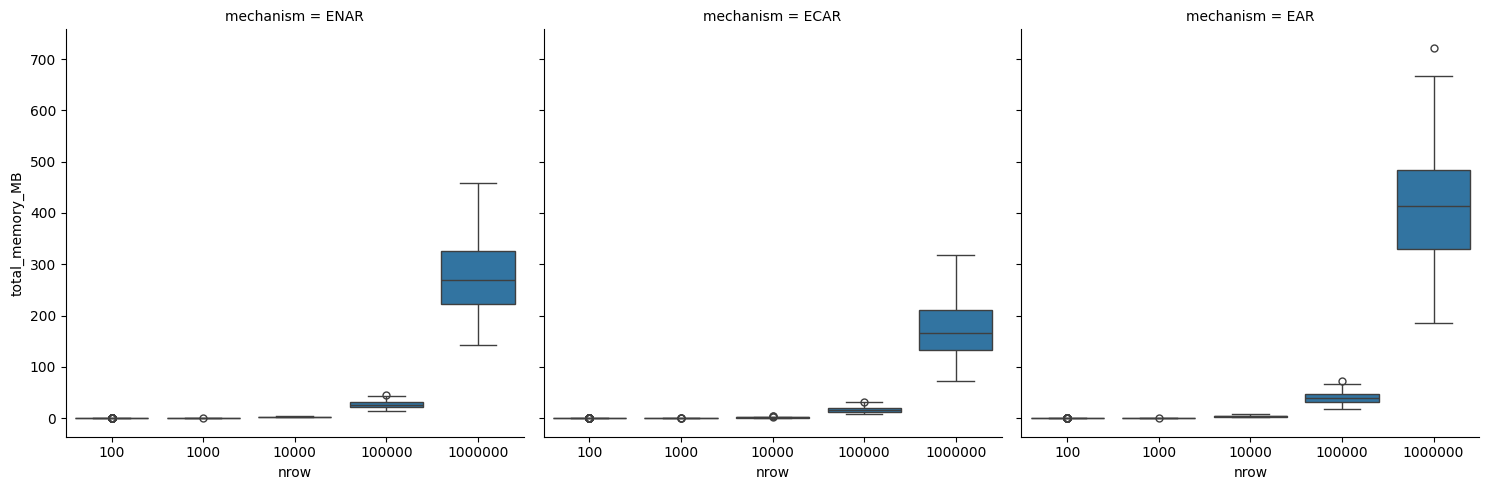

In [97]:
# Total memory allocated in the low level API aggregated across error rates, types (numeric), and ncol
# Plotted by mech
sns.catplot(df, x="nrow", y="total_memory_MB", col="mechanism", kind='box')

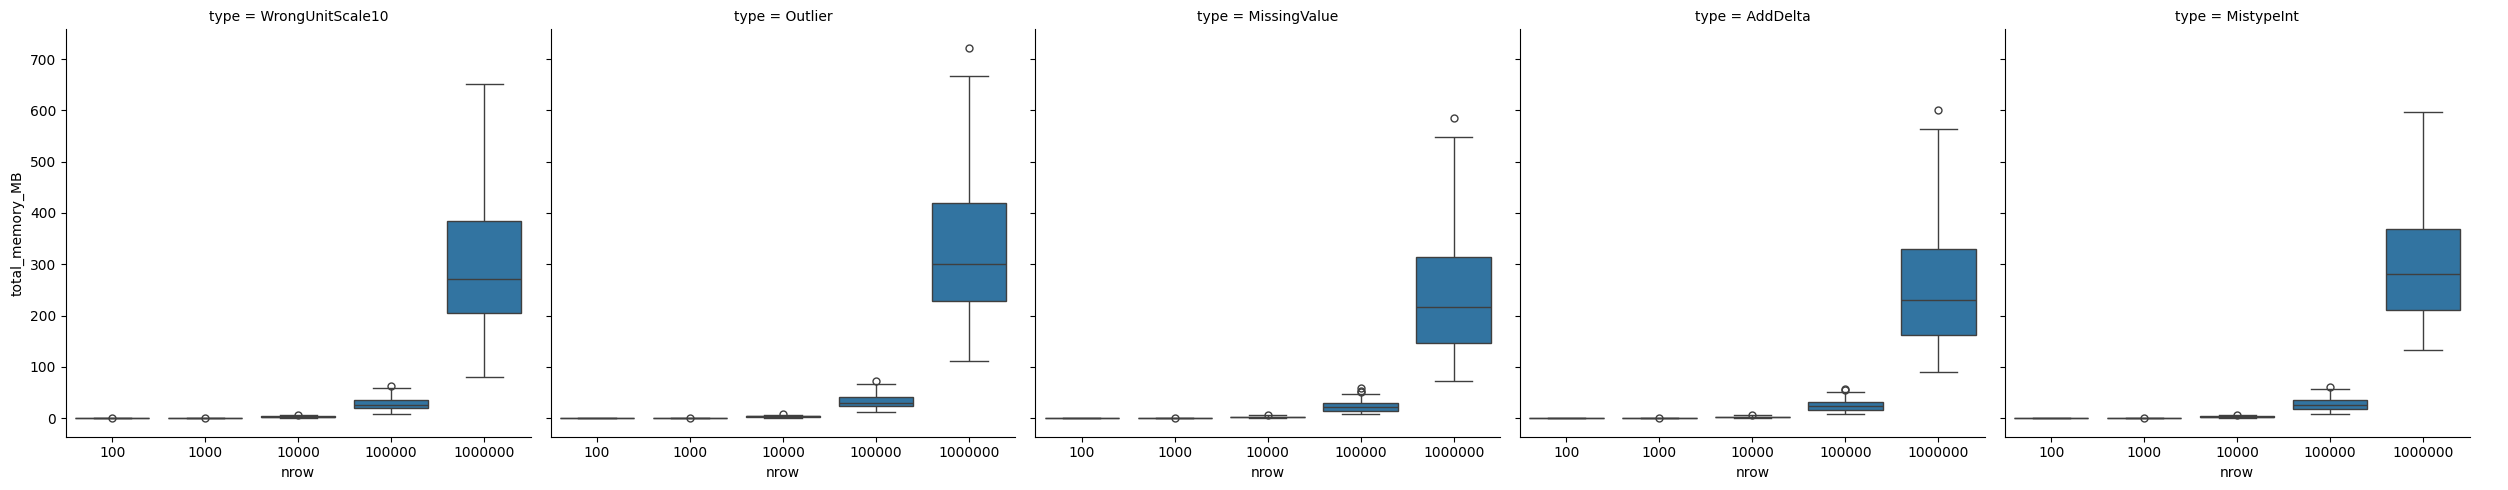

In [ ]:
# By type
sns.catplot(df, x="nrow", y="total_memory_MB", col="type", kind='box')


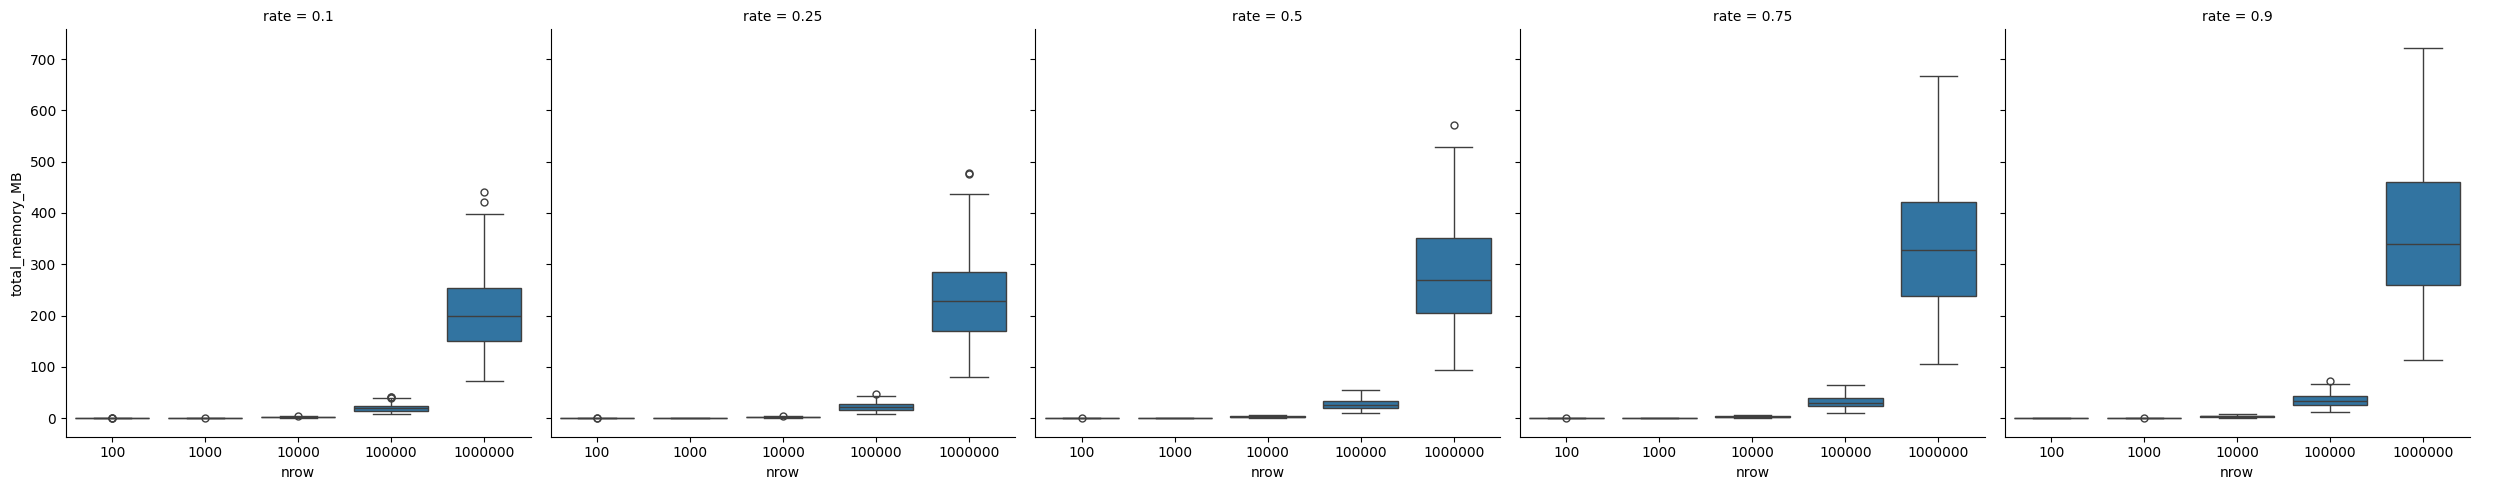

In [ ]:
# By rate
sns.catplot(df, x="nrow", y="total_memory_MB", col="rate", kind='box')

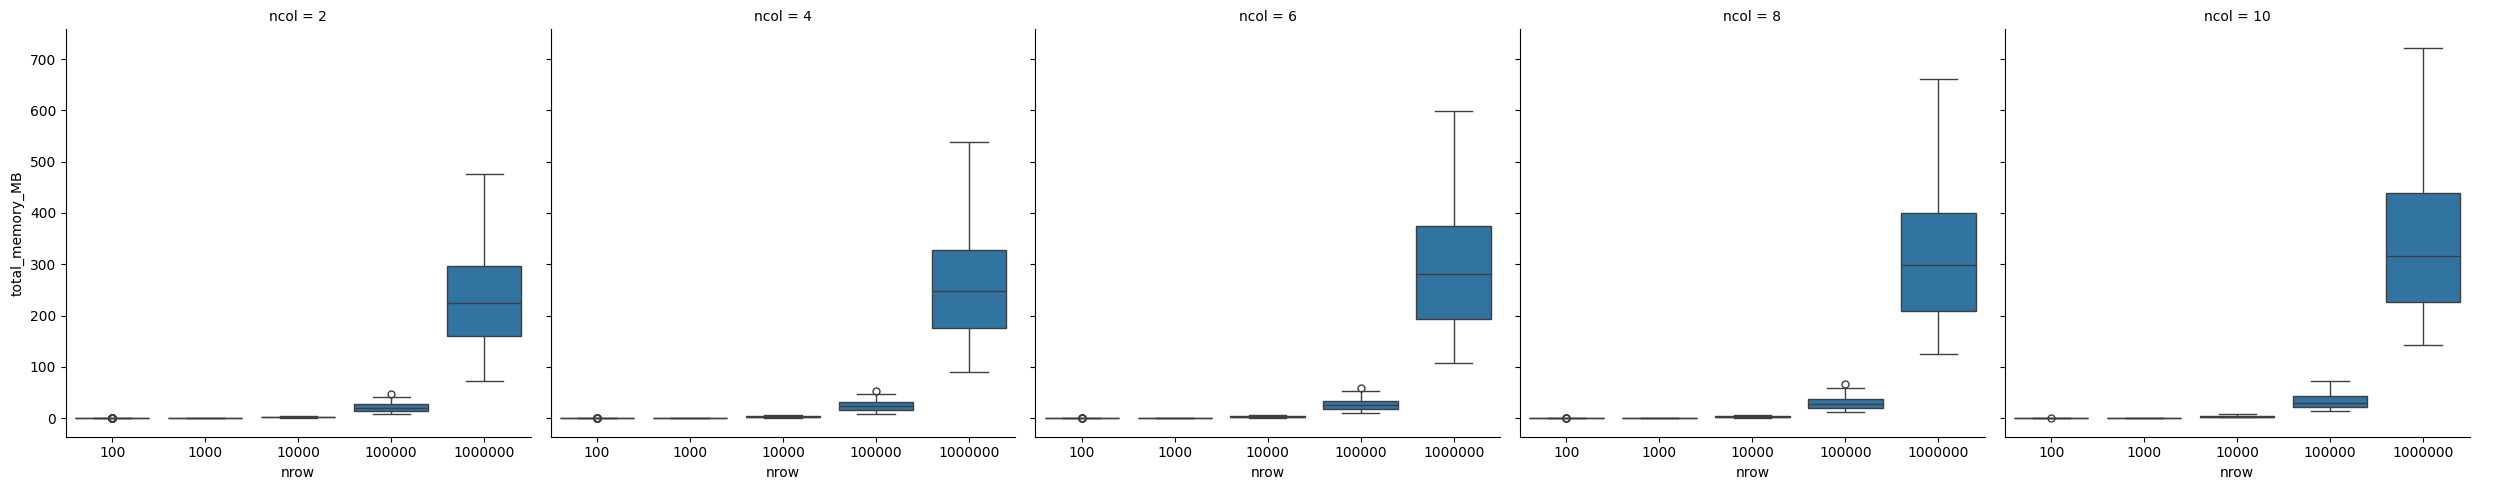

In [ ]:
# By ncol
sns.catplot(df, x="nrow", y="total_memory_MB", col="ncol", kind='box')

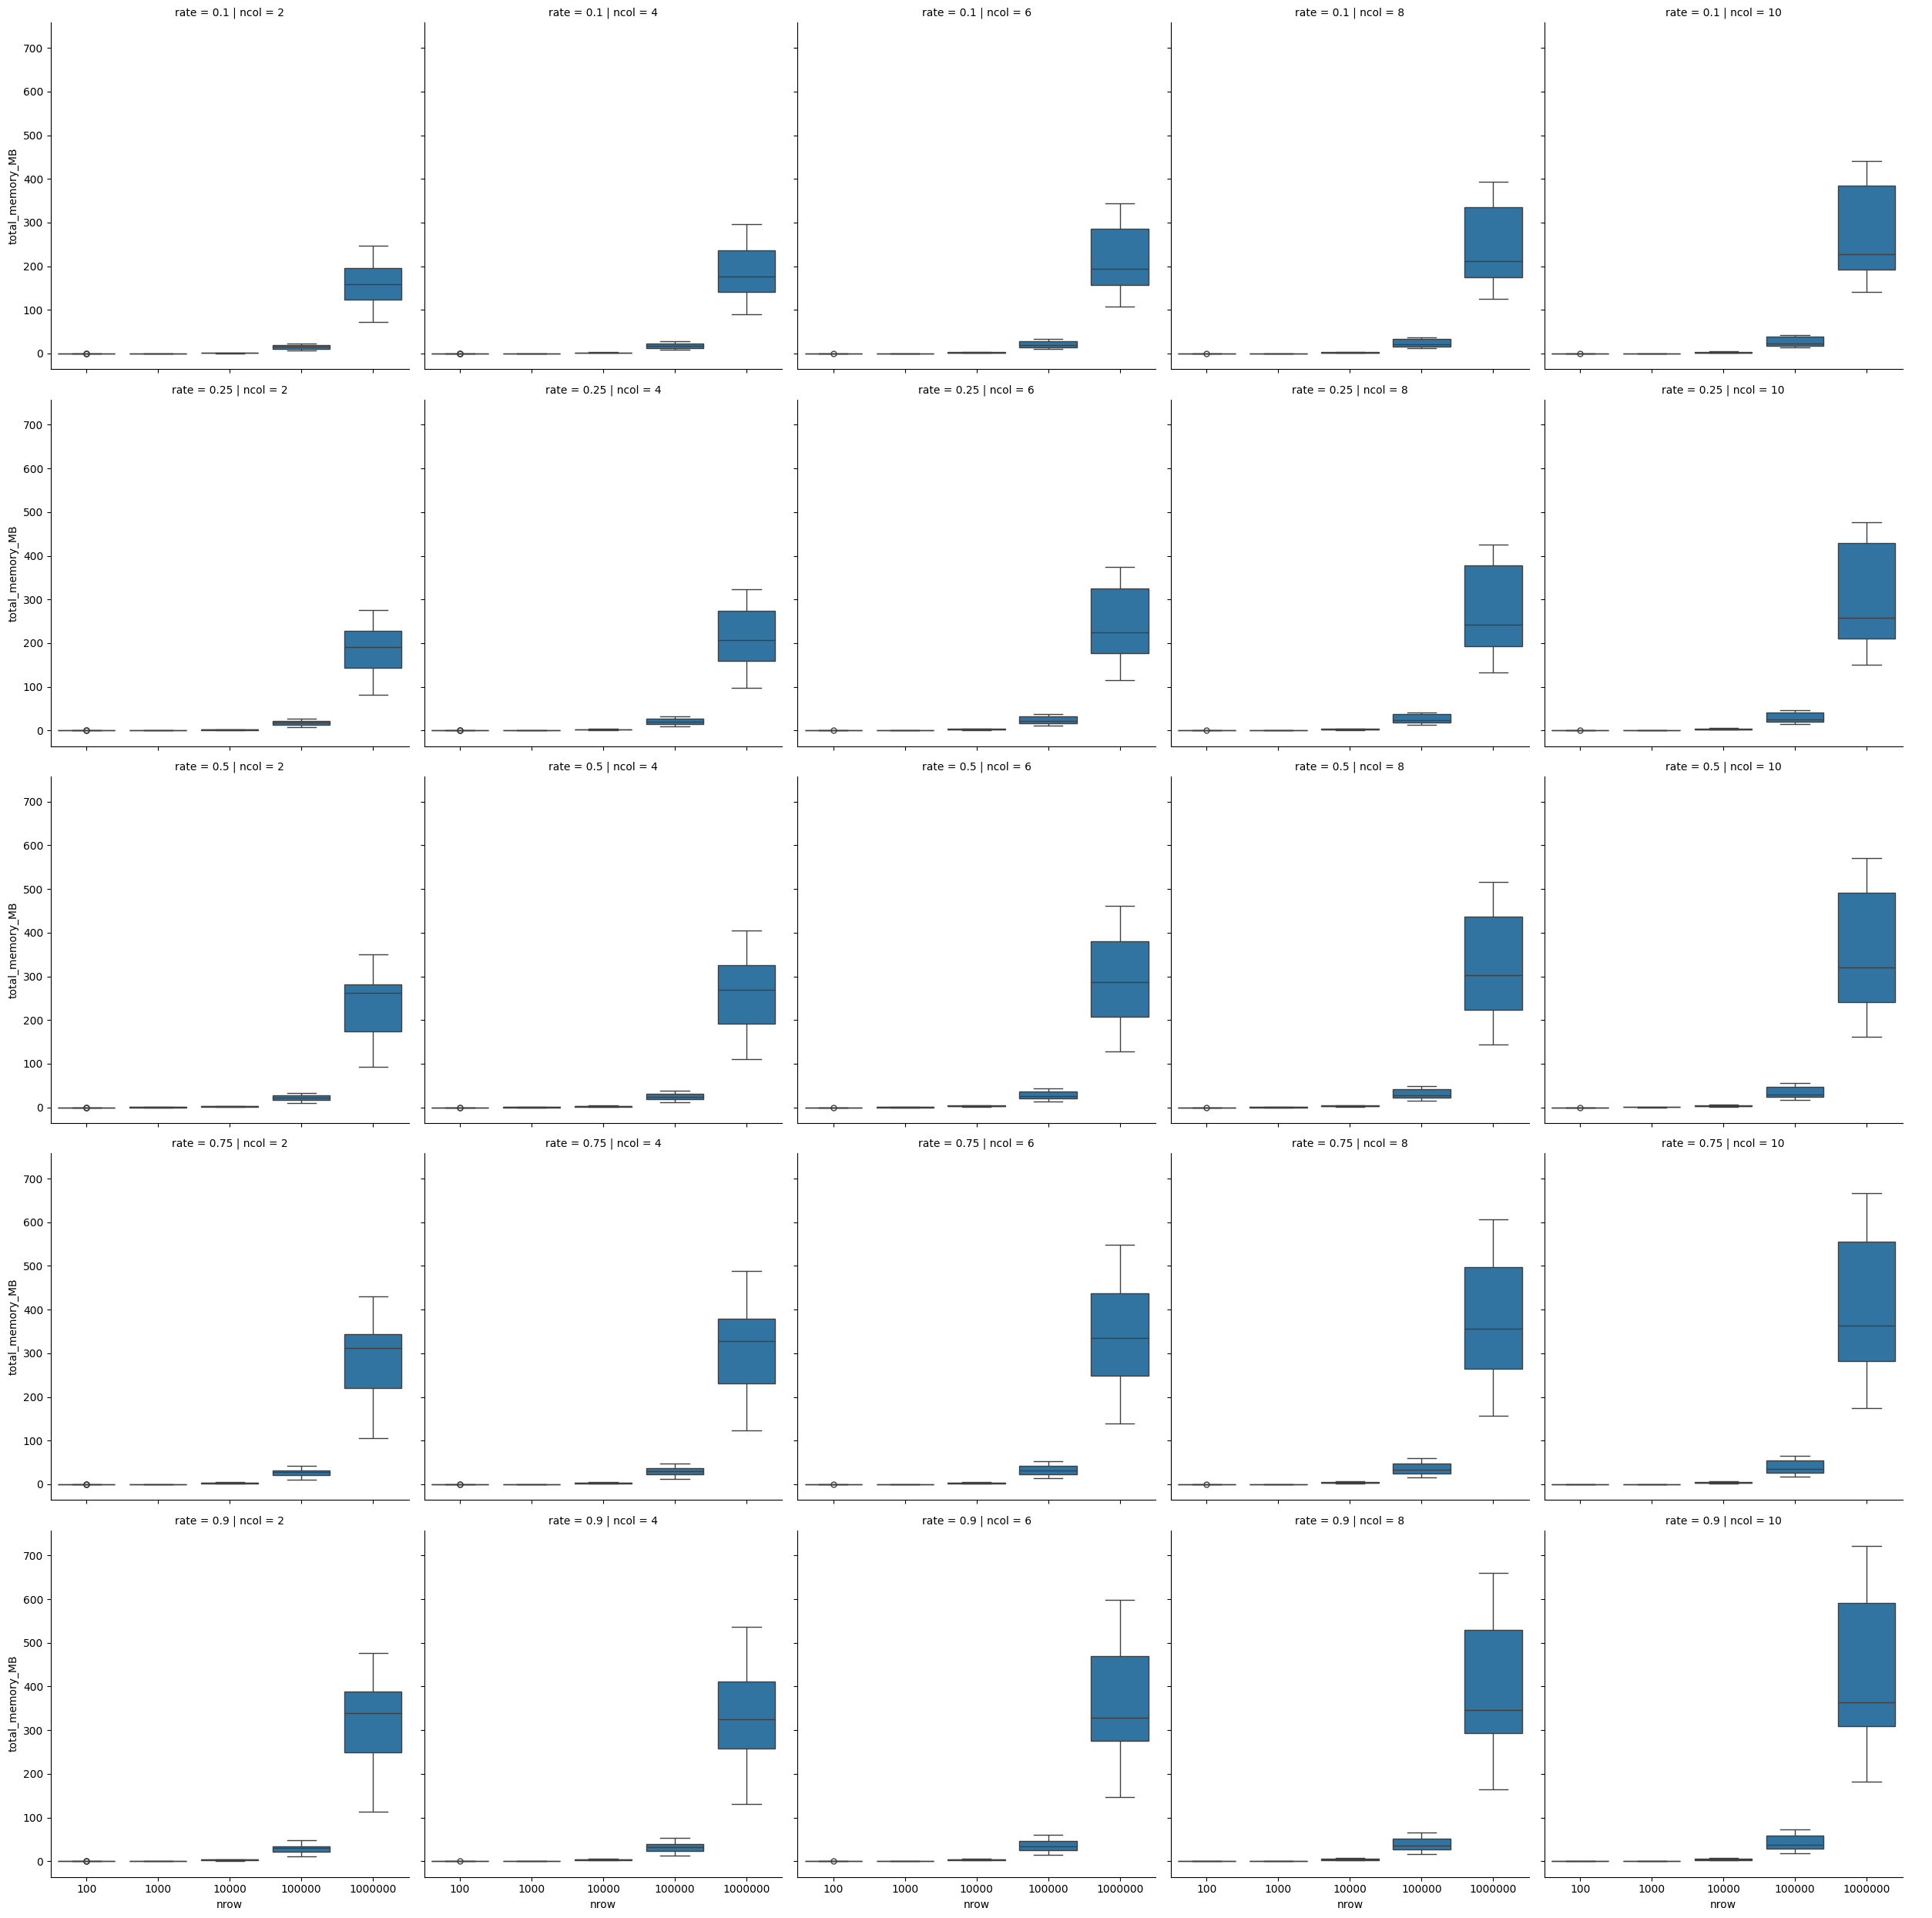

In [91]:
sns.catplot(df, x="nrow", y="total_memory_MB", col="ncol", row="rate", kind='box')

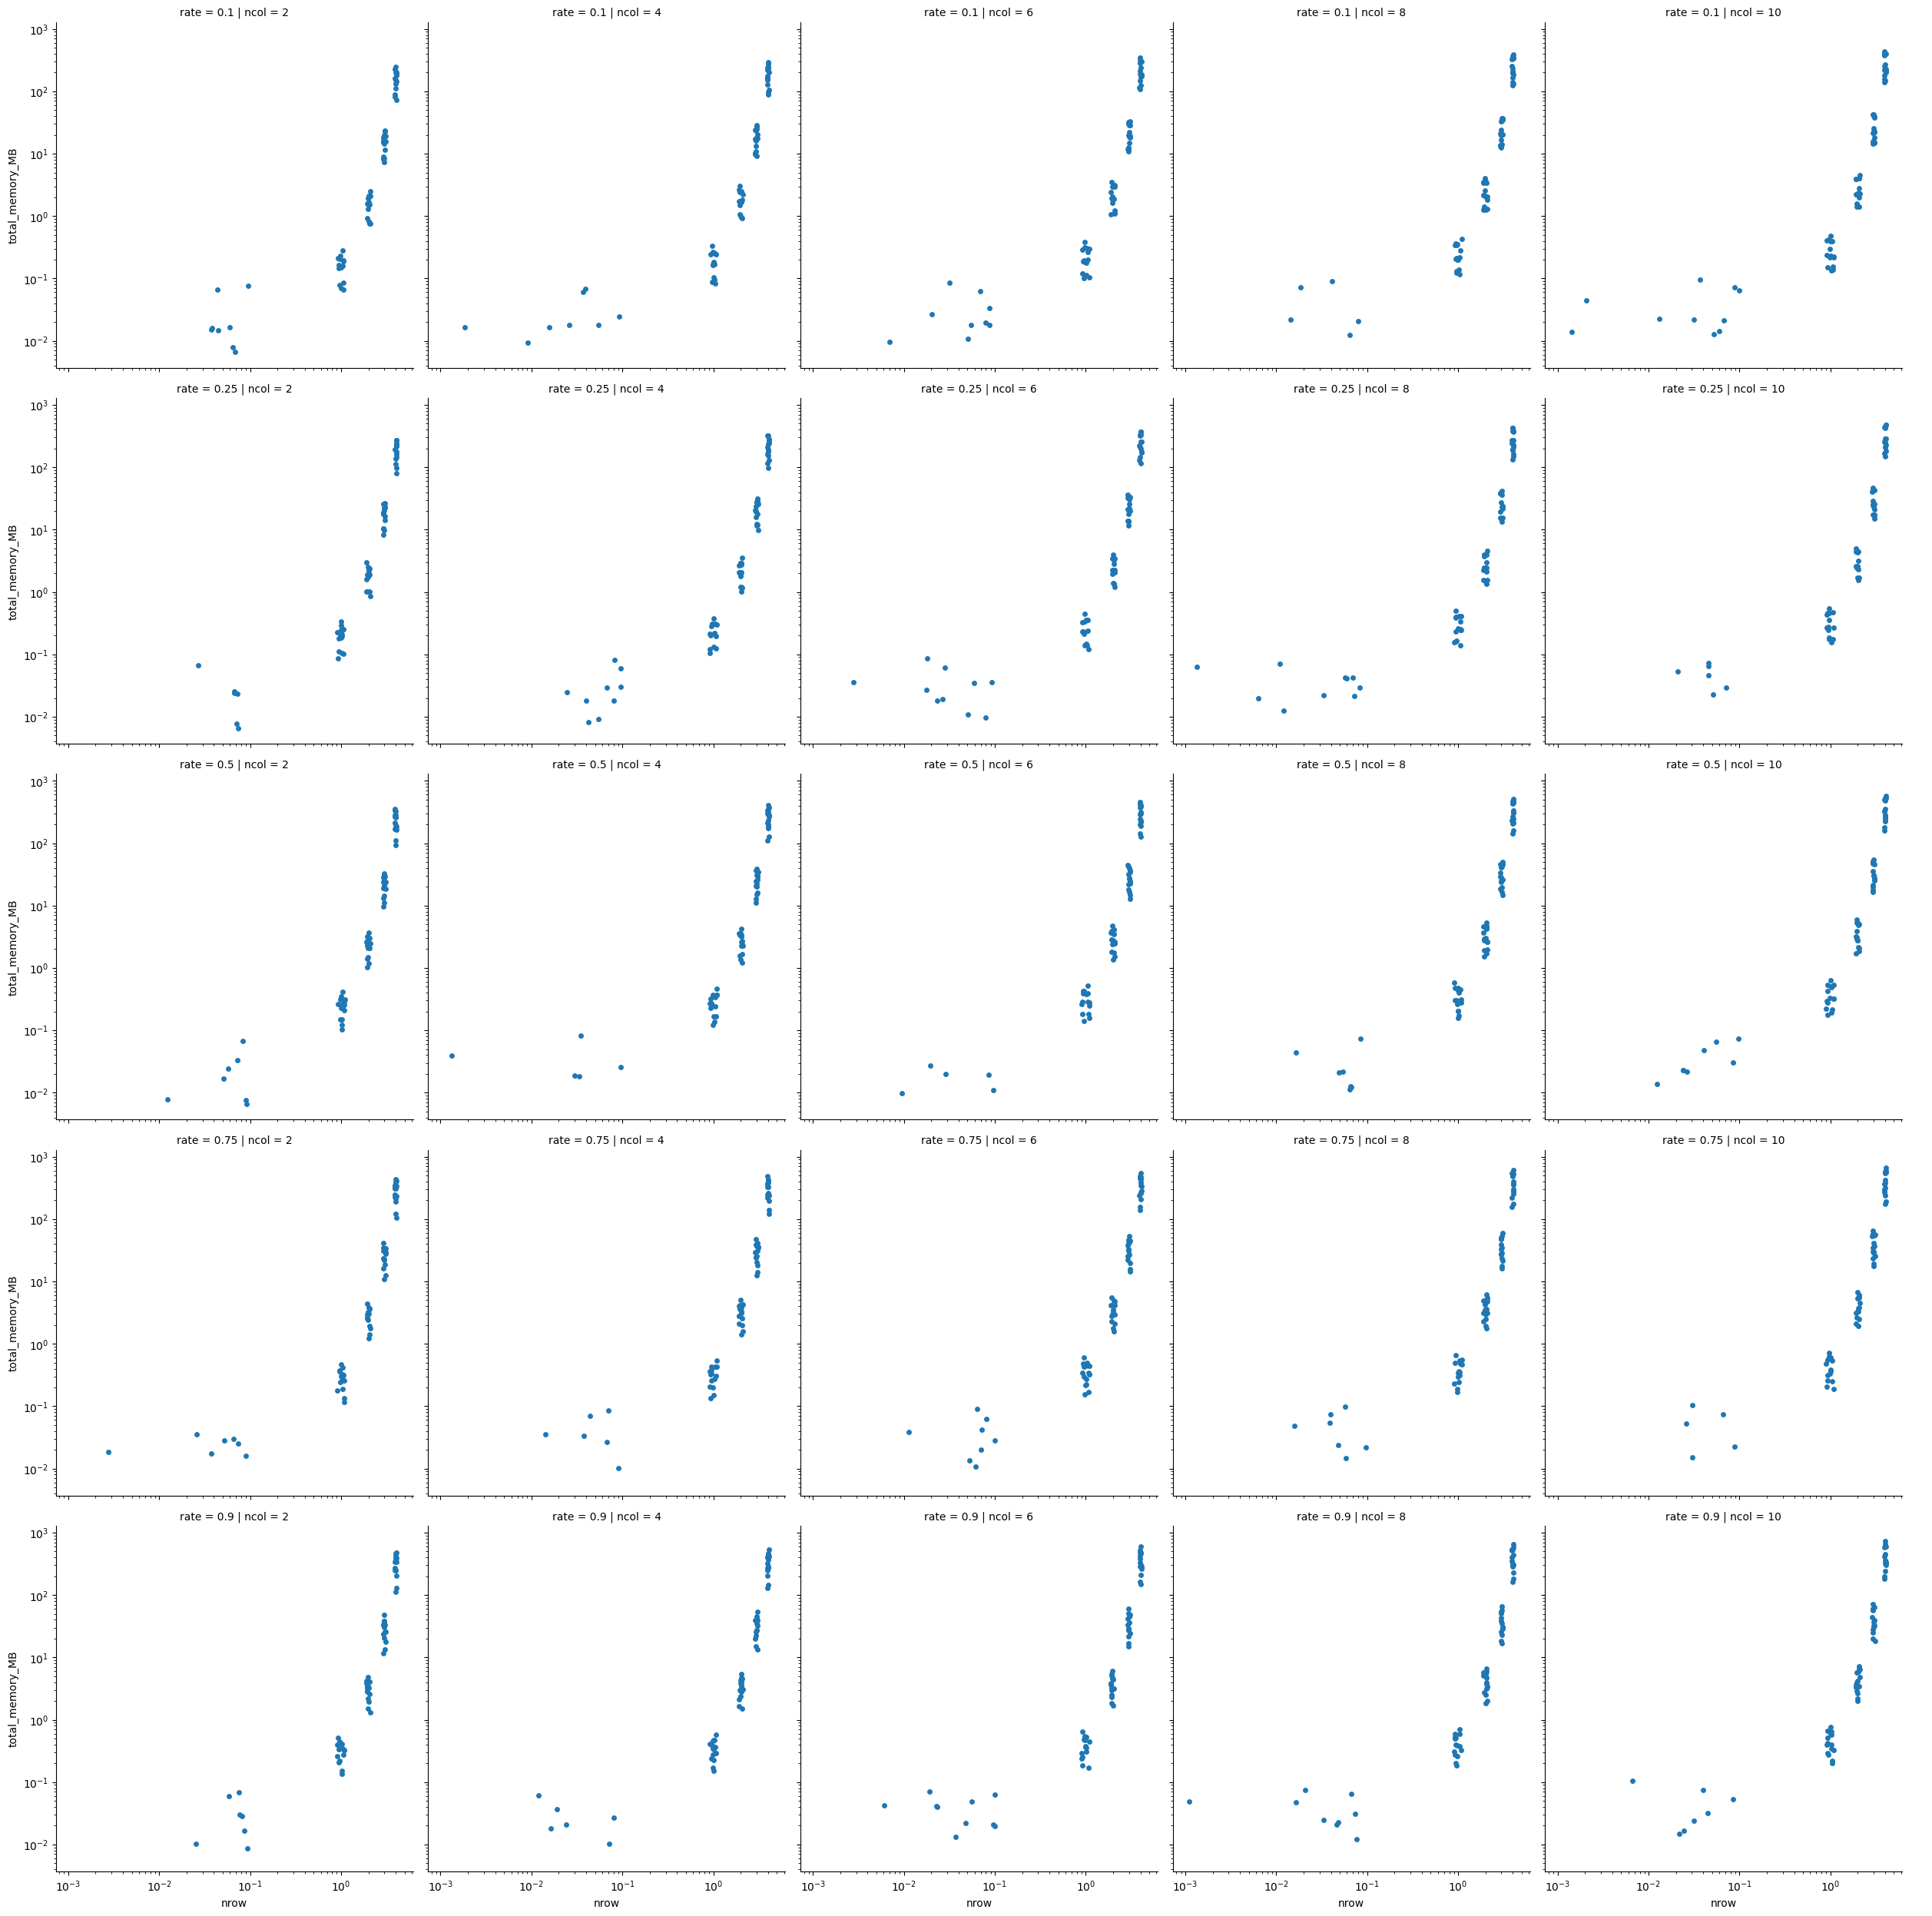

In [ ]:
g = sns.catplot(df, x="nrow", y="total_memory_MB", col="ncol", row="rate")
# Set log scale for all axes
for ax in g.axes.flat:
    ax.set_xscale('log')
    ax.set_yscale('log')
